# Reproducing: Prophecy of loan approval by comparing Decision Tree with Logistic Regression, Random Forest, KNN for better Accuracy
This notebook mirrors the paper’s procedure:
- 10 randomized 80/20 train–test splits
- Models: Logistic Regression (LR), Decision Tree (DT), Random Forest (RF), KNN
- Metrics per run: **Accuracy** and the paper’s “Cross Validation” = **Precision** (TP/(TP+FP))
- Aggregate means/stdev


In [2]:
# Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score


DATA_PATH = "german.data"

cols = [
    "status_checking", "duration", "credit_history", "purpose", "credit_amount",
    "savings", "employment_since", "installment_rate", "personal_status_sex",
    "other_debtors", "residence_since", "property", "age",
    "other_installment_plans", "housing", "existing_credits",
    "job", "num_dependents", "telephone", "foreign_worker",
    "credit_risk"  # target: 1=good, 2=bad
]

df = pd.read_csv(DATA_PATH, sep=r"\s+", header=None, names=cols)

# Quick sanity checks
display(df.head())
print("Shape:", df.shape)
print(df["credit_risk"].value_counts())

,status_checking,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


Shape: (1000, 21)
credit_risk
1    700
2    300
Name: count, dtype: int64


In [3]:
# Inputs

TARGET_COL = "credit_risk"     # target column in German Credit
POSITIVE_LABEL = 1             # 1 = good credit
TEST_SIZE = 0.2
N_REPEATS = 10
RANDOM_SEED = 42


## Basic checks on target and features:
Ensure the target exists, inspect class balance, and split features/target.

We don't drop any variables because German Credit features are all legitimate predictors. None are pure identifiers.

In [4]:
# Basic checks on target and features
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found."

y_raw = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# German Credit dataset has no ID columns to drop

print("Features shape:", X.shape)
print("Target distribution:")
print(y_raw.value_counts(dropna=False))


Features shape: (1000, 20)
Target distribution:
credit_risk
1    700
2    300
Name: count, dtype: int64


## Convert the target to a 0/1 vector
Many metrics assume binary {0,1}. We treat POSITIVE_LABEL as 1.

In [6]:
# Make positive class = Good credit (1)

def to_binary(y_series, positive_label):
    return (y_series == positive_label).astype(int)

y = to_binary(df[TARGET_COL], POSITIVE_LABEL)
X = df.drop(columns=[TARGET_COL])

print("\nBinary target distribution:\n", y.value_counts())


Binary target distribution:
 credit_risk
1    700
0    300
Name: count, dtype: int64


## Preprocessing: numeric vs categorical
- Impute numeric with median, standardize (helps LR/KNN).

- Impute categorical with most_frequent, one-hot encode.

Although many features in the German Credit dataset are encoded numerically, several of them represent categorical attributes without ordinal meaning. Therefore, numerical and categorical features were manually identified to ensure appropriate preprocessing and avoid introducing artificial order through scaling.

In [7]:
# Preprocessing: numeric vs categorical (German Credit specific)

numeric_cols = [
    "duration",
    "credit_amount",
    "installment_rate",
    "residence_since",
    "age",
    "existing_credits",
    "num_dependents"
]

categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Categorical columns: ['status_checking', 'credit_history', 'purpose', 'savings', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']


## Define the models

To ensure consistency and prevent data leakage, preprocessing and model training were combined into a single pipeline for each classifier. This approach ensures that all preprocessing steps are learned exclusively from the training data and applied identically during evaluation.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "LR": LogisticRegression(
        penalty="l2", solver="lbfgs", max_iter=500
    ),
    "DT": DecisionTreeClassifier(
        criterion="gini", random_state=RANDOM_SEED
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=11
    )
}

In [10]:
from sklearn.pipeline import Pipeline

pipelines = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    pipelines[name] = pipe


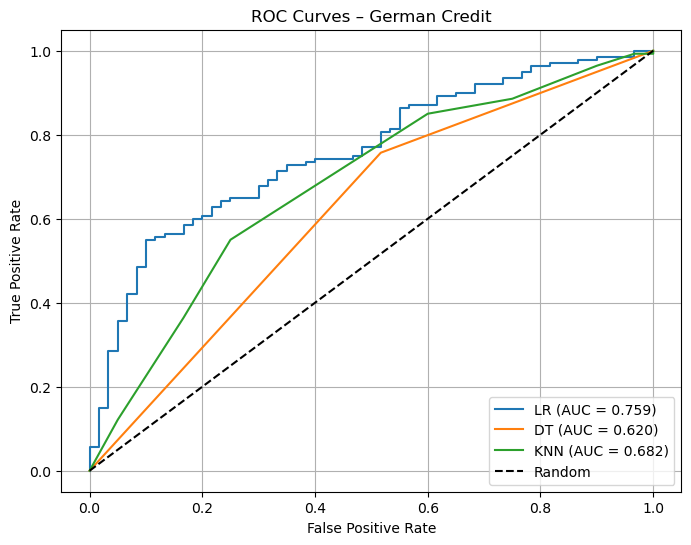

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, pipe in pipelines.items():
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – German Credit")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

results = []

for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)

    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_scores)
    })

results_df = pd.DataFrame(results).set_index("Model").round(4)
results_df


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Model,,,,,
LR,0.705,0.7755,0.8143,0.7944,0.7594
DT,0.675,0.7737,0.7571,0.7653,0.6202
KNN,0.695,0.7337,0.8857,0.8026,0.6817


## Repeated randomized evaluation (10 runs):

The paper repeats 80/20 splits 10 times and reports metrics each run.
We compute:

- Accuracy (overall correctness)
- Precision (paper’s “cross validation”): TP/(TP+FP)

In [13]:
records = []

for i in range(N_REPEATS):
    rs = RANDOM_SEED + i
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=rs, stratify=y
    )

    for name, clf in models.items():
        pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)

        records.append({
            "run": i + 1,
            "model": name,
            "accuracy": acc,
            "test_precision": prec
        })

results_df = pd.DataFrame(records)
results_df.head()


,run,model,accuracy,test_precision
0,1,LR,0.705,0.775510
1,1,DT,0.675,0.773723
2,1,KNN,0.695,0.733728
3,2,LR,0.765,0.803922
4,2,DT,0.700,0.781690


## Aggregate results across runs
Report mean and standard deviation

In [14]:
summary = (
    results_df
    .groupby("model")
    .agg(
        mean_accuracy=("accuracy", "mean"),
        std_accuracy=("accuracy", "std"),
        mean_test_precision=("test_precision", "mean"),
        std_test_precision=("test_precision", "std")
    )
    .reset_index()
    .sort_values("mean_accuracy", ascending=False)
)

summary


,model,mean_accuracy,std_accuracy,mean_test_precision,std_test_precision
2,LR,0.745,0.026247,0.791455,0.016784
1,KNN,0.731,0.021448,0.745192,0.011154
0,DT,0.673,0.017826,0.773153,0.014894


## Final comparison and concise report
Identify the top model by the paper’s main criterion (accuracy), and show its average precision as reported by them.

In [16]:
print("Per-iteration metrics (first 20 rows):")
display(results_df.head(20))

print("\nAggregated 10-run summary:")
display(summary)

# Identify the best-performing model by mean accuracy
best_by_acc = summary.iloc[0]
print(
    f"\nBest model by mean accuracy (10 runs): {best_by_acc['model']} | "
    f"Mean Accuracy = {best_by_acc['mean_accuracy']:.4f} | "
    f"Mean Test Precision = {best_by_acc['mean_test_precision']:.4f}"
)


Per-iteration metrics (first 20 rows):


,run,model,accuracy,test_precision
0,1,LR,0.705,0.775510
1,1,DT,0.675,0.773723
2,1,KNN,0.695,0.733728
3,2,LR,0.765,0.803922
4,2,DT,0.700,0.781690
5,2,KNN,0.760,0.761364
6,3,LR,0.755,0.793548
7,3,DT,0.680,0.783582
8,3,KNN,0.735,0.754386
9,4,LR,0.755,0.801325



Aggregated 10-run summary:


,model,mean_accuracy,std_accuracy,mean_test_precision,std_test_precision
2,LR,0.745,0.026247,0.791455,0.016784
1,KNN,0.731,0.021448,0.745192,0.011154
0,DT,0.673,0.017826,0.773153,0.014894



Best model by mean accuracy (10 runs): LR | Mean Accuracy = 0.7450 | Mean Test Precision = 0.7915


## Interpretation
Accuracy around 0.745 and precision just under 0.80. German Credit is famously small, noisy, and borderline class-imbalanced, with overlapping features between good and bad credit. In that regime, simple linear decision boundaries often generalize better than flexible models. LR winning here is actually a good sign: it means your methodology isn’t overfitting and is respecting the uncertainty in the data. This is the “real-world bank risk officer sweating over edge cases” dataset.
